In [1]:
# requirements to 

import json
from dotenv import load_dotenv
load_dotenv("../.env")

from openai import AzureOpenAI
import os

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-07-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

In [2]:
import pandas as pd

df = pd.read_csv("../data/Tifin_Test_1/data/sofmattress_train.csv")
df

,sentence,label
0,You guys provide EMI option?,EMI
1,Do you offer Zero Percent EMI payment options?,EMI
2,0% EMI.,EMI
3,EMI,EMI
4,I want in installment,EMI
...,...,...
323,May I please know about the offers,OFFERS
324,Available offers,OFFERS
325,Is offer available,OFFERS
326,Want to know the discount,OFFERS


In [13]:
uq_intents = (sorted(df['label'].unique())
            #   + ['UNKNOWN']
              )
uq_intents

['100_NIGHT_TRIAL_OFFER',
 'ABOUT_SOF_MATTRESS',
 'CANCEL_ORDER',
 'CHECK_PINCODE',
 'COD',
 'COMPARISON',
 'DELAY_IN_DELIVERY',
 'DISTRIBUTORS',
 'EMI',
 'ERGO_FEATURES',
 'LEAD_GEN',
 'MATTRESS_COST',
 'OFFERS',
 'ORDER_STATUS',
 'ORTHO_FEATURES',
 'PILLOWS',
 'PRODUCT_VARIANTS',
 'RETURN_EXCHANGE',
 'SIZE_CUSTOMIZATION',
 'WARRANTY',
 'WHAT_SIZE_TO_ORDER']

In [4]:
## This doesn't work for the model I am using.

# from pydantic import BaseModel

# class IntentClassification(BaseModel):
#     intent: str

# user_query = "Is offer available"

# completion = client.beta.chat.completions.parse(
#     model="gpt-4o-mini",
#     messages=[
#         {"role": "system", "content": system_message},
#         {
#             "role": "user",
#             "content": user_message.format(
#                 uq_intents_str=uq_intents_str, user_query=user_query
#             ),
#         },
#     ],
#     response_format=IntentClassification,
# )

In [14]:
from tqdm.notebook import tqdm
tqdm.pandas()

from functools import partial
from concurrent.futures import ThreadPoolExecutor

def process_batch(runner_func, sentences, max_workers=32):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(runner_func, sentences),
            total=len(sentences),
            desc="Processing intents"
        ))
    return results

In [15]:
# uq_intents_str = "\n".join(uq_intents)

def get_intent_openai(user_query):
    output_json_schema = { "intent" : "string" }

    system_message = "You are a helpful customer service representative."
    user_message = """Your job is to indentify the intent of the customer query.
The company is in the business of {company_bussiness}.
Pick only one intent from the list of intents provided below.
List of intents:
{uq_intents}

Provide the answer in the JSON format below.
{output_json_schema}

User Query:
{user_query}

Intent:
"""
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {
                "role": "user",
                "content": user_message.format(
                    company_bussiness="selling mattress",
                    uq_intents=uq_intents,
                    user_query=user_query,
                    output_json_schema=output_json_schema
                ),
            },
        ],
        response_format={ "type": "json_object" }
    ) 

    res = json.loads(completion.choices[0].message.content).get("intent") or "UNKNOWN"
    return res

In [17]:
df['intent'] = df['sentence'].progress_apply(get_intent_openai)

# df['intent'] = process_batch(get_intent_openai, df['sentence'].tolist())

  0%|          | 0/328 [00:00<?, ?it/s]

In [34]:
pred_col = 'intent'
accuracy = (df[pred_col] == df['label']).mean()
print(f"Accuracy: {accuracy:.2f}")

# wrong classifications
wrong_df = df[df[pred_col] != df['label']].reset_index(drop=True)
wrong_classification_count = wrong_df.shape[0]
print("Number of wrong classifications:", wrong_classification_count)

# wrong where predicted intent is UNKNOWN
unknown_count = (wrong_df[pred_col] == 'UNKNOWN').sum()
print(f"Number of unknown intents: {unknown_count}")

# wrong where predicted intent is not UNKNOWN
wrong_count = (wrong_df[pred_col] != 'UNKNOWN').sum()
print(f"Number of wrong intents: {wrong_count}")

Accuracy: 0.88
Number of wrong classifications: 39
Number of unknown intents: 0
Number of wrong intents: 39


## Findings after initial runs

1. give few shot examples to potentially improve it
2. let the model say "UNKNOWN" if it's not sure? could be helpful to flag cases where the prompt requires changes.
3. fix ambigious cases with specific instructions

### Few shot

In [35]:
# few shot
def get_intent_openai_few_shot(user_query, examples_str):
    output_json_schema = { "intent" : "string" }

    system_message = "You are a helpful customer service representative."
    user_message = """Your job is to indentify the intent of the customer query.
The company is in the business of {company_bussiness}.
Pick only one intent from the list of intents provided below.
List of intents:
{uq_intents}

Here are some example sentece and intent pairs:
{examples}


Provide the answer in the JSON format below:
{output_json_schema}

User Query:
{user_query}

Intent:
"""
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {
                "role": "user",
                "content": user_message.format(
                    company_bussiness="selling mattress",
                    uq_intents=uq_intents,
                    examples=examples_str,
                    user_query=user_query,
                    output_json_schema=output_json_schema
                ),
            },
        ],
        response_format={ "type": "json_object" }
    ) 

    res = json.loads(completion.choices[0].message.content).get("intent") or "UNKNOWN"
    return res

In [43]:
# take one example from each label randomly
from functools import partial

examples = df.groupby("label")[['sentence', 'label']].apply(
    lambda x: x.sample(n=1, random_state=0)
).reset_index(drop=True)

examples_str = "\n".join(
    f"\"{row['sentence']}\": \"{row['label']}\""
    for _, row in examples.iterrows()
)
print(examples_str)


get_intent_openai_few_shot_random = partial(get_intent_openai_few_shot, examples_str=examples_str)

"What is the 100-night offer": "100_NIGHT_TRIAL_OFFER"
"Tell me about SOF mattresses": "ABOUT_SOF_MATTRESS"
"Cancel order": "CANCEL_ORDER"
"Is delivery possible on this pincode": "CHECK_PINCODE"
"Can pay later on delivery ": "COD"
"Product comparison": "COMPARISON"
"It's delayed": "DELAY_IN_DELIVERY"
"Nearby Show room": "DISTRIBUTORS"
"I want it on 0% interest": "EMI"
"Ergo features": "ERGO_FEATURES"
"Interested in buying": "LEAD_GEN"
"Mattress cost": "MATTRESS_COST"
"Give me some discount": "OFFERS"
"Track order": "ORDER_STATUS"
"What are the key features of the SOF Ortho mattress": "ORTHO_FEATURES"
"Pillows": "PILLOWS"
" Which mattress is best": "PRODUCT_VARIANTS"
"Looking to exchange": "RETURN_EXCHANGE"
"Can mattress size be customised?": "SIZE_CUSTOMIZATION"
"Does mattress cover is included in warranty": "WARRANTY"
"King Size": "WHAT_SIZE_TO_ORDER"


In [44]:
df['intent_few_shot_random'] = df['sentence'].progress_apply(get_intent_openai_few_shot_random)

# df['intent_few_shot_random'] = process_batch(get_intent_openai_few_shot_random, df['sentence'].tolist())

  0%|          | 0/328 [00:00<?, ?it/s]

In [55]:
pred_col = 'intent_few_shot_random'
#Accuracy
accuracy = (df[pred_col] == df['label']).mean()
print(f"Accuracy: {accuracy:.2f}")

# wrong classifications
wrong_df = df[df[pred_col] != df['label']].reset_index(drop=True)
wrong_classification_count = wrong_df.shape[0]
print("Number of wrong classifications:", wrong_classification_count)

# wrong where predicted intent is UNKNOWN
unknown_count = (wrong_df[pred_col] == 'UNKNOWN').sum()
print(f"Number of unknown intents: {unknown_count}")

# wrong where predicted intent is not UNKNOWN
wrong_count = (wrong_df[pred_col] != 'UNKNOWN').sum()
print(f"Number of wrong intents: {wrong_count}")

Accuracy: 0.95
Number of wrong classifications: 18
Number of unknown intents: 0
Number of wrong intents: 18


                       precision    recall  f1-score   support

100_NIGHT_TRIAL_OFFER       1.00      0.89      0.94        18
   ABOUT_SOF_MATTRESS       0.59      0.91      0.71        11
         CANCEL_ORDER       1.00      1.00      1.00        10
        CHECK_PINCODE       1.00      1.00      1.00        10
                  COD       1.00      1.00      1.00        12
           COMPARISON       1.00      0.82      0.90        11
    DELAY_IN_DELIVERY       0.92      1.00      0.96        11
         DISTRIBUTORS       1.00      0.94      0.97        34
                  EMI       1.00      1.00      1.00        25
        ERGO_FEATURES       1.00      0.73      0.84        11
             LEAD_GEN       0.84      1.00      0.91        21
        MATTRESS_COST       0.96      1.00      0.98        22
               OFFERS       0.91      1.00      0.95        10
         ORDER_STATUS       1.00      0.95      0.98        21
       ORTHO_FEATURES       0.94      0.88      0.91  

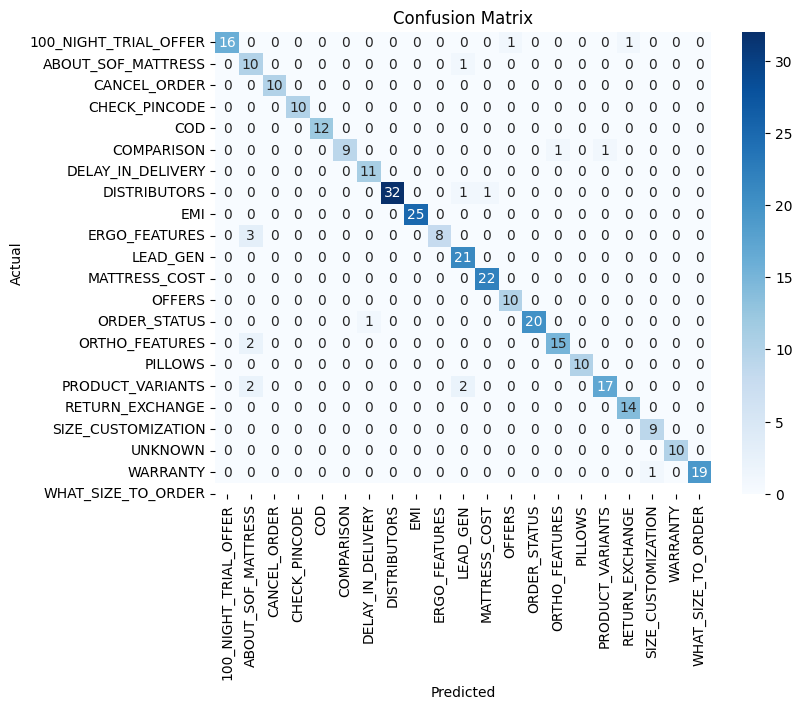

,sentence,label,intent,intent_few_shot_random
0,SOF ortho,ORTHO_FEATURES,ABOUT_SOF_MATTRESS,ABOUT_SOF_MATTRESS
1,Tell me about SOF Ortho mattress,ORTHO_FEATURES,ABOUT_SOF_MATTRESS,ABOUT_SOF_MATTRESS
2,Ergo mattress,ERGO_FEATURES,ABOUT_SOF_MATTRESS,ABOUT_SOF_MATTRESS
3,Tell me about SOF Ergo mattress,ERGO_FEATURES,ABOUT_SOF_MATTRESS,ABOUT_SOF_MATTRESS
4,What is responsive foam,ERGO_FEATURES,ABOUT_SOF_MATTRESS,ABOUT_SOF_MATTRESS
5,Which mattress to buy?,COMPARISON,LEAD_GEN,PRODUCT_VARIANTS
6,Is the mattress good for my back,COMPARISON,ORTHO_FEATURES,ORTHO_FEATURES
7,do you provide exchange,100_NIGHT_TRIAL_OFFER,RETURN_EXCHANGE,RETURN_EXCHANGE
8,I want to check offers,100_NIGHT_TRIAL_OFFER,OFFERS,OFFERS
9,Want to know the custom size chart,WHAT_SIZE_TO_ORDER,SIZE_CUSTOMIZATION,SIZE_CUSTOMIZATION


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

pred_col = 'intent_few_shot_random'
report = classification_report(df['label'], df[pred_col], zero_division=0)
print(report)

cm = confusion_matrix(df['label'], df[pred_col])

actual_labels = sorted([*df['label'].unique(), "UNKNOWN"])
predicted_labels = sorted(df[pred_col].unique())


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=predicted_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

wrong_df

## More experiment
### Few shot examples from the failed cases of zero shot

In [47]:
# take one example from each label randomly
wrong_examples = wrong_df.groupby("label")[['sentence', 'label']].apply(
    lambda x: x.sample(n=2, replace=True, random_state=0)
).reset_index(drop=True)

missing_labels = set(df['label'].unique()) - set(wrong_examples['label'].unique())
correct_examples = df[df['label'].isin(missing_labels)].groupby("label")[['sentence', 'label']].apply(
    lambda x: x.sample(n=1, random_state=42)
).reset_index(drop=True)

combined_examples = pd.concat([wrong_examples, correct_examples], ignore_index=True).drop_duplicates()


combined_examples = combined_examples.sort_values("label").reset_index(drop=True)

combined_examples_str = "\n".join(
    f"\"{row['sentence']}\": \"{row['label']}\""
    for _, row in combined_examples.iterrows()
)
print(combined_examples_str)



get_intent_openai_few_shot_specific = partial(get_intent_openai_few_shot, examples_str=combined_examples_str)

"do you provide exchange": "100_NIGHT_TRIAL_OFFER"
"I want to check offers": "100_NIGHT_TRIAL_OFFER"
"Tell me about company": "ABOUT_SOF_MATTRESS"
"Process of cancelling order": "CANCEL_ORDER"
"Need a delivery on this pincode": "CHECK_PINCODE"
"Can I get COD option?": "COD"
"Which mattress to buy?": "COMPARISON"
"Is the mattress good for my back": "COMPARISON"
"Almost 1 month over": "DELAY_IN_DELIVERY"
"What is the price for size (x ft x y ft)? What is the price for size (x inches x y inches)?": "DISTRIBUTORS"
"Head office": "DISTRIBUTORS"
"I need emi payment. ": "EMI"
"Ergo mattress": "ERGO_FEATURES"
"Tell me about SOF Ergo mattress": "ERGO_FEATURES"
"Get in Touch": "LEAD_GEN"
"Price of mattress": "MATTRESS_COST"
"Want to know the discount ": "OFFERS"
"When can we expect": "ORDER_STATUS"
"Tell me about SOF Ortho mattress": "ORTHO_FEATURES"
"SOF ortho": "ORTHO_FEATURES"
"Can I also have pillows": "PILLOWS"
"Tell me about SOF mattress features": "PRODUCT_VARIANTS"
"I want to buy a mattr

In [48]:
df['intent_few_shot_specific_filled'] = df['sentence'].progress_apply(get_intent_openai_few_shot_specific)
# df['intent_few_shot_specific_filled'] = process_batch(get_intent_openai_few_shot_specific, df['sentence'].tolist(), max_workers=8)

  0%|          | 0/328 [00:00<?, ?it/s]

In [51]:
pred_col = 'intent_few_shot_specific_filled'
#Accuracy
accuracy = (df[pred_col] == df['label']).mean()
print(f"Accuracy: {accuracy:.2f}")

# wrong classifications
wrong_df = df[df[pred_col] != df['label']].reset_index(drop=True)
wrong_classification_count = wrong_df.shape[0]
print("Number of wrong classifications:", wrong_classification_count)

# wrong where predicted intent is UNKNOWN
unknown_count = (wrong_df[pred_col] == 'UNKNOWN').sum()
print(f"Number of unknown intents: {unknown_count}")

# wrong where predicted intent is not UNKNOWN
wrong_count = (wrong_df[pred_col] != 'UNKNOWN').sum()
print(f"Number of wrong intents: {wrong_count}")

Accuracy: 0.92
Number of wrong classifications: 26
Number of unknown intents: 0
Number of wrong intents: 26
